UFC Fight Prediction Using Random Forest

Overview

This project builds a UFC fight prediction model using the Random Forest Classifier. The workflow involves data cleaning, feature engineering, hyperparameter tuning, training the model, and making predictions on new fights.

1. Load and Clean Data

Read the dataset

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score

In [2]:
# get the file path
def get_file_path(folder, file_name):
    return os.path.dirname(os.getcwd()) + "\\" + folder + "\\" + file_name

# read json file
def read_file(folder="data\\transformed", file_name=None):
    return pd.read_csv(get_file_path(folder, file_name))

training_data = read_file(file_name="training_data.csv")
training_data

,fighter_name_a,fighter_name_b,result,weight_class,event_date_a,sign_str_successful_a,sign_str_attempts_a,total_str_successful_a,total_str_attempts_a,td_successful_a,...,Win Streak_b,win_by_DEC_b,win_by_KOTKO_b,win_by_SUB_b,win_by_Other_b,loss_by_DEC_b,loss_by_DIS_b,loss_by_Other_b,loss_by_SUB_b,loss_by_KOTKO_b
0,Igor Vovchanchyn,Francisco Bueno,a,NaN,1999-11-21,10.60,24.60,45.20,61.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mark Hominick,NaN,a,Lightweight,2006-06-28,14.00,47.00,18.00,51.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mickey Gall,CM Punk,a,Welterweight,2016-09-10,2.00,4.00,3.00,5.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Dustin Ortiz,Jussier Formiga,b,NaN,2016-09-24,15.43,33.79,28.86,48.86,0.86,...,0.0,20.0,0.0,16.0,0.0,4.0,0.0,0.0,0.0,4.0
4,Ian McCall,Brad Pickett,a,Flyweight,2014-07-19,18.23,47.46,29.69,59.85,0.54,...,0.0,7.0,7.0,10.0,0.0,3.0,0.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10326,BJ Penn,NaN,a,Lightweight,2004-05-22,11.71,17.59,30.65,36.88,1.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10327,Hideo Tokoro,NaN,b,Featherweight,2008-12-31,20.00,57.00,42.33,83.33,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10328,Sanae Kikuta,NaN,a,NaN,2005-12-31,2.73,6.82,23.73,31.45,0.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10329,Ken Shamrock,NaN,b,NaN,1996-05-17,5.75,9.88,34.50,41.50,0.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. Handle missing values and remove unnecessary columns and  Filter out non-relevant results

In [3]:
# Drop N/A values
training_data = training_data.dropna(subset=["fighter_name_a", "fighter_name_b","weight_class","event_date_a","event_date_b"])

training_data["Losses_a"] = training_data.Losses_a.fillna(0)

# Drop columns that are not features
non_feature_columns = [
    "fighter_name_a",
    "fighter_name_b",
    "event_date_a",
    "event_date_b",
]


# Remove any draw or nc from the result column
training_data = training_data[~training_data.result.str.contains("draw")]
training_data = training_data[~training_data.result.str.contains("nc")]

training_data = training_data.drop_duplicates()

# drop weight class null 
training_data = training_data.dropna(subset=["weight_class"])

training_data.fillna(0, inplace=True)



clean_training_data = training_data.copy()

clean_training_data.shape

clean_training_data

C:\Users\rapha.LAPTOP-O2D0M81G\AppData\Local\Temp\ipykernel_38840\3786734510.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data["Losses_a"] = training_data.Losses_a.fillna(0)


(8601, 80)

2. Feature Engineering

Convert categorical features into numerical values


In [4]:
# transform weight class to numerical values
weight_class_encoder = LabelEncoder()
weight_class_encoder.fit(clean_training_data["weight_class"])

clean_training_data["weight_class"] = weight_class_encoder.transform(
    clean_training_data["weight_class"]
)

In [5]:
# split features and target (results)
X = clean_training_data.drop(columns=non_feature_columns)
X = X.drop(columns=["result"])
y = clean_training_data["result"]

Split features and target variable

In [6]:
# encode the target
le = LabelEncoder()
y = le.fit_transform(y)

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42
)

3. Train Model

Split data and tune hyperparameters using RandomizedSearchCV

In [7]:
param_dist = {
    "n_estimators": randint(100, 500),  # More trees improve stability
    "max_depth": randint(5, 30),  # Prevent overly deep trees
    "min_samples_split": randint(2, 20),  # Avoid overfitting small splits
    "max_features": ["sqrt", "log2", None],  # Control number of features per split
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=50,  # Increase if you have time for better tuning
    scoring="accuracy",  # We use accuracy as our metric
    random_state=42,
    n_jobs=-1,  # Use all available CPUs for efficiency
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)

Best Parameters: {'max_depth': 9, 'max_features': None, 'min_samples_split': 8, 'n_estimators': 336}
Best Accuracy Score: 0.6321220930232558


Train final model with optimal parameters and evalute accuracy

In [14]:
# train the model
model = RandomForestClassifier(
    max_depth=9,
    max_features=None,
    min_samples_split=8,
    n_estimators=336,
    random_state=42,
)
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6449738524113887


Feature Importance Visualization

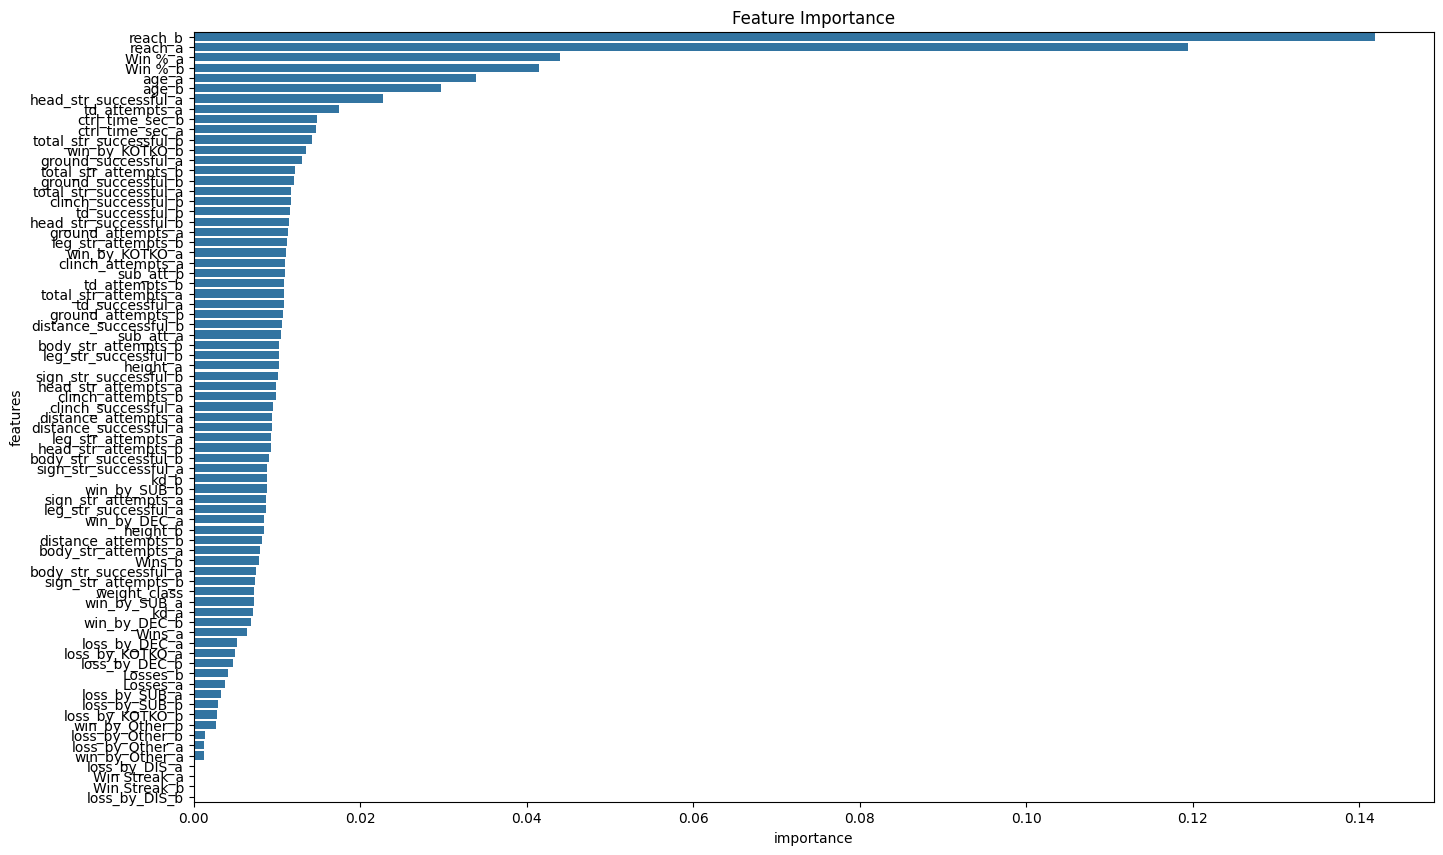

In [15]:
# Visualize the model the most important features
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = model.feature_importances_
features = X.columns
df = pd.DataFrame({"features": features, "importance": feature_importances})
df = df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x=df["importance"], y=df["features"])
plt.title("Feature Importance")
plt.show()

5. Match Prediction

Prepare fighter match data

In [16]:
def df_selection(df):

    # Delete result column
    df = df.drop(columns=["result"])

    # find all columns ending with a and b
    fighter_columns = [col for col in df.columns if col.endswith("_a")]
    opponent_columns = [col for col in df.columns if col.endswith("_b")]

    # select all columns ending with a and b
    df_a, df_b = df[fighter_columns], df[opponent_columns]

    # remove the suffixes
    df_a.columns = [col[:-2] if col.endswith("_a") else col for col in df_a.columns]
    df_b.columns = [col[:-2] if col.endswith("_b") else col for col in df_b.columns]

    df = pd.concat([df_a, df_b], axis=1)

    # remove duplicate column & order by event date
    df = df.loc[:, ~df.columns.duplicated()]
    df = df.sort_values(by="event_date", ascending=False)

    # get most recent per fighter
    df = df.drop_duplicates(subset=["fighter_name"], keep="first")

    return df

In [17]:
selection_df = df_selection(training_data)


Create fight matchup features

In [18]:
def create_match(
    selection_df: pd.DataFrame,
    fighter_a: str | list,
    fighter_b: str | list,
    weight_class: str | list
) -> pd.DataFrame:

    if isinstance(fighter_a, str):
        fighter_a = [fighter_a]
        fighter_b = [fighter_b]
        weight_class = [weight_class]

    if len(fighter_a) != len(fighter_b) or len(fighter_a) != len(weight_class):
        raise ValueError("The number of fighters and weight_classes must be the same")

    # Remove event date from the selection_df
    selection_df = selection_df.drop(columns=["event_date"])

    # get the most recent data for each fighter
    fighter_a_data = selection_df.set_index("fighter_name").loc[fighter_a].reset_index()
    fighter_b_data = selection_df.set_index("fighter_name").loc[fighter_b].reset_index()

    # rename the columns add suffixes

    fighter_a_data.columns = [f"{col}_a" for col in fighter_a_data.columns]
    fighter_b_data.columns = [f"{col}_b" for col in fighter_b_data.columns]

    # reset the index
    fighter_a_data = fighter_a_data.reset_index(drop=True)
    fighter_b_data = fighter_b_data.reset_index(drop=True)

    # merge on index
    features = pd.concat([fighter_a_data, fighter_b_data], axis=1)

    # weight class to series
    features["weight_class"] = pd.Series(weight_class)

    # transform weight class to numerical values
    features["weight_class"] = weight_class_encoder.transform(features["weight_class"])

    # weight class as first column
    features = features[
        ["weight_class"] + [col for col in features.columns if col != "weight_class"]
    ]

    return features

Predict fight outcomes

In [19]:
# Function to predict the outcome of a fight


def predict_outcome(training_data, features: pd.DataFrame) -> pd.DataFrame:

    # train model on all the data
    model = RandomForestClassifier(
        max_depth=7, min_samples_split=7, n_estimators=236, random_state=42
    )

    X, y = clean_training_data.drop(columns=non_feature_columns), training_data["result"]

    X = X.drop(columns=["result"])
    y = le.fit_transform(y)

    model.fit(X, y)

    # remove fighter_name
    x = features.drop(columns=["fighter_name_a", "fighter_name_b"])

    # change x sequence to match the training data
    x = x[X.columns]

    # make predictions
    y_pred = model.predict(x)

    # add probability of the winning class
    y_pred_proba = model.predict_proba(x)
    y_pred_proba = y_pred_proba.max(axis=1)

    # if b than loss else win
    y_pred = ["loss" if result == 1 else "win" for result in y_pred]

    predictions_df = pd.DataFrame(
        {
            "Fighter": features["fighter_name_a"].values,
            "Opponent": features["fighter_name_b"].values,
            # original y values
            "Result": y_pred,
            "Vote Share": y_pred_proba,
        }
    )

    return predictions_df


features = create_match(
    selection_df,
    fighter_a=[
        "Alex Pereira",
        "Jon Jones",
        "Islam Makhachev",
        "Alexander Volkanovski",
        "Belal Muhammad",
        "Paddy Pimblett",
        "Khamzat Chimaev",
    ],
    fighter_b=[
        "Magomed Ankalaev",
        "Tom Aspinall",
        "Ilia Topuria",
        "Diego Lopes",
        "Jack Della Maddalena",
        "Michael Chandler",
        "Dricus Du Plessis",
    ],
    weight_class=[
        "Light Heavyweight",
        "Heavyweight",
        "Lightweight",
        "Featherweight",
        "Welterweight",
        "Lightweight",
        "Middleweight",
    ],
)


outcome = predict_outcome(training_data, features)

outcome

,Fighter,Opponent,Result,Vote Share
0,Alex Pereira,Magomed Ankalaev,loss,0.535175
1,Jon Jones,Tom Aspinall,win,0.527267
2,Islam Makhachev,Ilia Topuria,loss,0.511045
3,Alexander Volkanovski,Diego Lopes,win,0.527974
4,Belal Muhammad,Jack Della Maddalena,loss,0.515924
5,Paddy Pimblett,Michael Chandler,win,0.541478
6,Khamzat Chimaev,Dricus Du Plessis,win,0.559229


In [ ]:
x